In [149]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Import relevant packages
%matplotlib inline
import matplotlib
from matplotlib.pyplot import cm
import numpy as np
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

**Partial Differential Equation (PDE) Solvers**

Let's now shift our focus on a specfic PDE, for example, the **Korteweg-de Vries** ([KdV](https://mathworld.wolfram.com/Korteweg-deVriesEquation.html)) equation.


The KdV euqation (1985) is a model of shallow water waves:

The PDE equation governing the above simulation is:

$$
\frac{\delta U}{\delta t}(x,t) = - U(x,t) * \frac{\delta U}{\delta x}(x,t) - \frac{\delta^{3}U}{\delta x^{3}}(x,t)
$$

**Boundary Conditions**

The boundary conditions express the behaviour of a function on the boundary (border) of its area of definitions. 
For example, you constrain that at both ends of the spatial domain $x_{0}$ and $x_{L}$ (where L is the end of your spatial domain) the function remains constant for all time:
$$
\frac{\delta U}{\delta x}(x_{0},t)=\frac{\delta U}{\delta x}(x_{L},t)=0
 $$ 
 $$ \forall t
 $$

**Initial Conditions**

An initial condition is similar to boundary conditions, but now in the time direction. For example, now you constrain what value your function U(x,t) must return at timepoint t=0. 




Initial conditions are sampled from a distribution over truncated Fourier series with random coefficients 
$\{A_k, \ell_k, \phi_k\}_k$ as
$$
    U(x,0) = \sum_{k=1}^N A_k \sin(2 \pi \ell_k x / L + \phi_k) \ .
$$

In [150]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    N = 10 #Number of different waves
    lmin, lmax = 1, 3 #sine frequencies for intial conditions
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    if params is None:
        params = generate_params()
    N, A, phi, l = params   
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u


#### Solve via Method of Lines (MOL)
In MOL all but the temporal dimension are discretized. Having the spatial derivatives numerically implemented results in a set of coupled ODEs for the time domain, which can be solved by using integration schemes of ODE solving.

Concretely, for getting numerical spatial derivatives, we use [pseudospectral methods](https://en.wikipedia.org/wiki/Pseudo-spectral_method), where the derivatives are computed in the frequency domain by first applying a fast fourier transform (FFT) to the data, then multiplying by the appropriate values and converting back to the spatial domain with the inverse FFT. 

Mathematically this works since the Fourier transform of the $n$th derivative is given by:

$$
\widehat{f^{(n)}} (\xi) = \mathcal{F} \bigg( \frac{d^n}{dx^n} f(x) \bigg) = (2\pi i \xi)^n \widehat{f}(\xi) \ ,
$$

where $\widehat{f^{(n)}}$ is the mathematical denotation of fourier transform of a function $f$, the transform variable $\xi$ represents frequency, $f(x)$ is an absolutely continuous differentiable function, and both $f$ and its derivative $f′$ are integrable (for more information see [wikipedia](https://en.wikipedia.org/wiki/Fourier_transform#Tables_of_important_Fourier_transforms) section Functional relations). This method of differentiation in the Fourier space is implemented by the `diff` function in the module `scipy.fftpack`.
For integration in time we use an **implicit Runge-Kutta method** of Radau IIA family, order 5.

In [151]:
# Spatial Derivatives
def kdv_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    # Compute du/dt.    
    dudt = -u*ux - uxxx
    return dudt


In [152]:
# Set the size of the domain, and create the discretized grid.
np.random.seed(1)
L = 128
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)

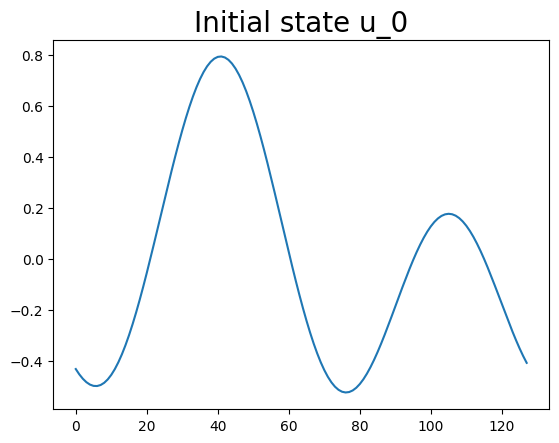

In [153]:
plt.plot(u0)
plt.title('Initial state u_0', fontsize=20)
plt.show();

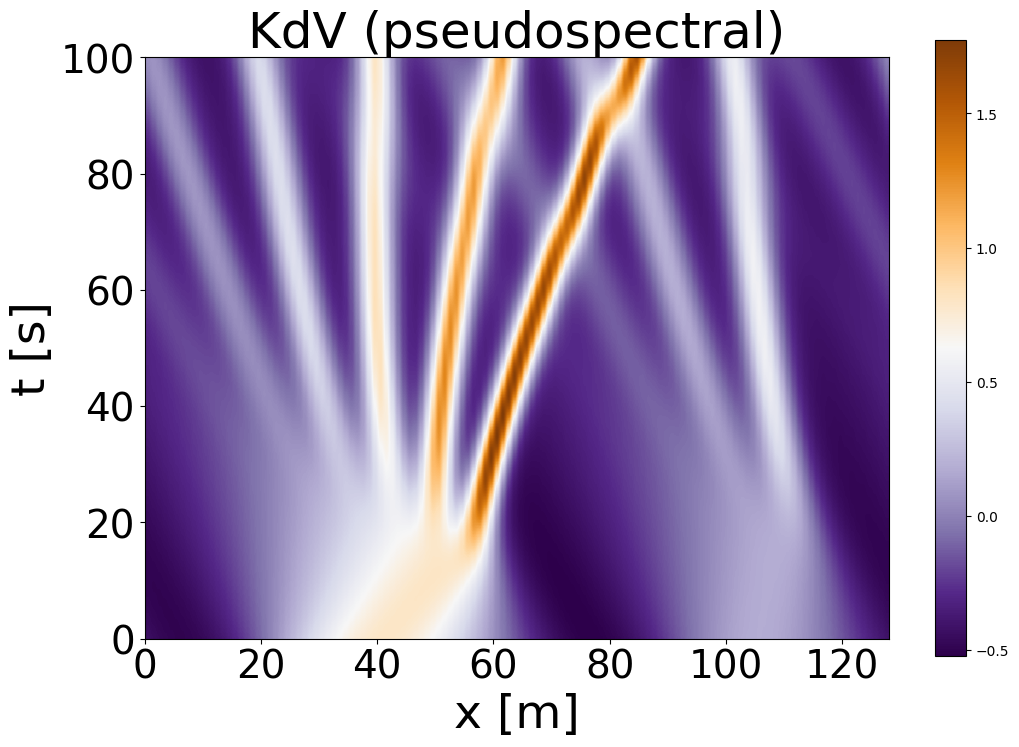

In [154]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

In [155]:
plt.rcParams["animation.html"] = "jshtml"

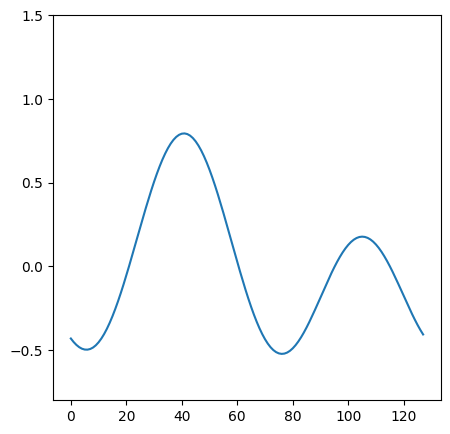

In [156]:
fig, ax = plt.subplots(figsize=(5,5))
t_ps_anim = np.flipud(t_ps)

def animate(t):
    plt.cla()
    plt.ylim([-0.8, 1.5])
    plt.plot(t_ps_anim[t,:])

matplotlib.animation.FuncAnimation(fig, animate, frames=200, interval=20)

### Neural Operators

The neural operator is **mesh-independent**, this is different from standard ML methods such as CNNs. The func-to-func mapping perspective allow us to: (i) first use a numerical solver to generate some low-resolution data, (ii) then train a neural operator on this data, (iii) but now the learned NO is able to give also high-resolution predictions, despite being trained on low-resolution data. This makes both, the training and the evaluation, easier.

What Li et al. (2020) proposed is to set the above kernel integral operator, $(K u_{t})(x)$, as a convolution operator defined in Fourier space. Why is this desirable?
- it's fast: convolution in one domain (spatial domain) equals **point-wise multiplication** in the frequency domain ([convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem))
- it's efficient: the inputs and outputs of PDEs are continous functions, so it's more efficient to represent them in Fourier space.

Hence, the **Fourier Integral Operator** is:
$$
(Ku_{t})(x) = 𝐹^{-1}(R_{\phi}⋅(𝐹u_{t}))(x)
$$

where $R_{\phi}$ is the linear tranform of the lower Fourier modes. Let's break down what is happening in the above function:
- first we do a Fourier transform: $(Fu_{t})(x)$
- then a linear transform: $R \cdot ()$
- and lastly we perform an inverse fourier transform: $F^{-1}(\cdot)$

In the image below we have depicted a complete **Fourier layer** ($v(x)$ is $u(x)$ in our notation):

**Fourier Integral Operator**

In [157]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

In [158]:
################################################################
#  1d Fourier Integral Operator
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x
    

In [159]:
################################################################
#  1d Fourier Network
################################################################
class FNO1d(nn.Module):
    def __init__(self, modes, width, time_future, time_history):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: a driving function observed at T timesteps + 1 locations (u(1, x), ..., u(T, x),  x). 
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """
        self.modes = modes
        self.width = width
        self.time_future = time_future
        self.time_history = time_history
        self.fc0 = nn.Linear(self.time_history+1, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.time_future)

    def forward(self, u):
        grid = self.get_grid(u.shape, u.device)
        x = torch.cat((u, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

    

In [160]:
import h5py
import torch
from typing import Tuple
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

#function to torch dataloader from the dataset
def create_dataloader(data_string: str, mode: str, nt: int, nx: int, batch_size:int, num_workers:int):
    try:
        dataset = HDF5Dataset(data_string,mode,nt=nt,nx=nx)
        loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
    except:
        raise Exception("Datasets could not be loaded properly")
        
    return loader


#Function to format the data in the correct format
def to_coords(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Transforms the coordinates to a tensor X of shape [time, space, 2].
    Args:
        x: spatial coordinates
        t: temporal coordinates
    Returns:
        torch.Tensor: X[..., 0] is the space coordinate (in 2D)
                      X[..., 1] is the time coordinate (in 2D)
    """
    x_, t_ = torch.meshgrid(x, t)
    x_, t_ = x_.T, t_.T
    return torch.stack((x_, t_), -1)

#Helper class to open the .h5 formated file
class HDF5Dataset(Dataset):
    """
    Load samples of an PDE Dataset, get items according to PDE.
    """
    def __init__(self, path: str,
                 mode: str,
                 nt: int,
                 nx: int,
                 dtype=torch.float64,
                 load_all: bool=False):
        """Initialize the dataset object.
        Args:
            path: path to dataset
            mode: [train, valid, test]
            nt: temporal resolution
            nx: spatial resolution
            shift: [fourier, linear]
            pde: PDE at hand
            dtype: floating precision of data
            load_all: load all the data into memory
        """
        super().__init__()
        f = h5py.File(path, 'r')
        self.mode = mode
        self.dtype = dtype
        self.data = f[self.mode]
        self.dataset = f'pde_{nt}-{nx}'


        if load_all:
            data = {self.dataset: self.data[self.dataset][:]}
            f.close()
            self.data = data

    def __len__(self):
        return self.data[self.dataset].shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns data items for batched training/validation/testing.
        Args:
            idx: data index
        Returns:
            torch.Tensor: data trajectory used for training/validation/testing
            torch.Tensor: dx
            torch.Tensor: dt
        """
        u = self.data[self.dataset][idx]
        x = self.data['x'][idx]
        t = self.data['t'][idx]
        dx = self.data['dx'][idx]
        dt = self.data['dt'][idx]

       
        if self.mode == "train":
            X = to_coords(torch.tensor(x), torch.tensor(t))
            sol = (torch.tensor(u), X)

            u = sol[0]
            X = sol[1]
            dx = X[0, 1, 0] - X[0, 0, 0]
            dt = X[1, 0, 1] - X[0, 0, 1]
        else:
            u = torch.from_numpy(u)
            dx = torch.tensor([dx])
            dt = torch.tensor([dt])
        return u.float(), dx.float(), dt.float()

#function to create x - y data pairs: 20 past timepoints as x, 20 future timepoints as y
def create_data(datapoints: torch.Tensor, start_time: list, time_future: int, time_history: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Getting data of PDEs for training, validation and testing.
    Args:
        datapoints (torch.Tensor): trajectory input
        start_time (int list): list of different starting times for different trajectories in one batch
        pf_steps (int): push forward steps
    Returns:
        torch.Tensor: neural network input data
        torch.Tensor: neural network labels
    """
    data = torch.Tensor()
    labels = torch.Tensor()
    # Loop over batch and different starting points
    # For every starting point, we take the number of time_history points as training data
    # and the number of time future data as labels
    for (dp, start) in zip(datapoints, start_time):
        end_time = start+time_history
        d = dp[start:end_time]
        target_start_time = end_time 
        target_end_time = target_start_time + time_future
        l = dp[target_start_time:target_end_time]

        data = torch.cat((data, d[None, :]), 0)
        labels = torch.cat((labels, l[None, :]), 0)

    return data, labels

In [161]:
################################################################
#  configurations
################################################################

#Experiment Settings
ntrain = 512 #train samples
nt = 140 #temporal resolution
nx = 256 #spatial resoltuion
time_history = 20 #time steps to be considered as input to the solver
time_future = 20 #time steps to be considered as output of the solver
device = 'cpu'  #change to cpu of no cuda available
print_interval = 20

#model parameters
modes = 16 # number of Fourier modes to multiply
width = 64 # input and output channels to the FNO layer
batch_size = 16
num_epochs = 1 #set to one so faster computation, in principle 20 is best
learning_rate = 0.0001
lr_decay = 0.4 
num_workers = 0

In [163]:
################################################################
# read data
################################################################
train_loader = create_dataloader("UVA_DeepNotebook\data\KdV_train_10_1_3_512_easy.h5", mode="train", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)
valid_loader = create_dataloader("UVA_DeepNotebook\data\KdV_valid_10_1_3_easy.h5", mode="valid", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)
test_loader = create_dataloader("UVA_DeepNotebook\data\KdV_test_10_1_3_easy.h5", mode = "test", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)

In [164]:
import operator
from functools import reduce
# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

# model
model = FNO1d(modes, width, time_future, time_history).to(device)
print('Number of paramters: {}'.format(count_params(model)))

Number of paramters: 553236


In [165]:
# Optimizer
from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 5, 10, 15], gamma=lr_decay)


In [166]:
criterion = torch.nn.MSELoss(reduction="none")

In [174]:
import random

def bootstrap(x: torch.Tensor, Nboot: int=64, binsize: int=1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Bootstrapping mean or median to obtain standard deviation.
    Args:
        x (torch.Tensor): input tensor, which contains all the results on the different trajectories of the set at hand
        Nboot (int): number of bootstrapping steps, 64 is quite common default value
        binsize (int):
    Returns:
        torch.Tensor: bootstrapped mean/median of input
        torch.Tensor: bootstrapped variance of input
    """
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(torch.mean(x[torch.randint(len(x), (len(x),))], axis=(0, 1)))
    return torch.tensor(boots).mean(), torch.tensor(boots).std()

def training_loop(loader,model, optimizer, criterion, device, batch_size):
  """
  Training loop.
  Loop is over the mini-batches and for every batch we pick a random timestep.
  This is done iteratively for the number of timesteps in one training sample.
  One average, we therefore start at every starting point in every trajectory during one episode.
  Args:
      model (torch.nn.Module): neural network model
      optimizer (torch.optim): chosen optimizer
      loader (DataLoader): train/valid/test dataloader
      criterion (torch.nn.modules.loss): loss criterion
      device: device (cpu/gpu)
  """
  losses = []
  max_start_time = (nt - time_history) - time_future
  for (u, _, _) in loader:
      optimizer.zero_grad()
      start_time = random.choices([t for t in range(time_history, max_start_time + 1, time_history)], k=batch_size)
      
      data, labels = create_data(u, start_time, time_history, time_future)
      data, labels = data.to(device), labels.to(device)

      # Change [batch, time, space] -> [batch, space, time]
      data = data.permute(0, 2, 1)

      #forward pass
      pred = model(data)

      loss = criterion(pred.permute(0, 2, 1), labels)
      loss = loss.sum()
      loss.backward()
      losses.append(loss.detach() / batch_size)
      optimizer.step()

  losses = torch.stack(losses)
  return losses

def test(loader,model,criterion, device, batch_size):
    """
    Test routine.
    Both step wise losses and enrolled forward losses are computed.
    Args:
        model (torch.nn.Module): neural network model
        loader (DataLoader): train/valid/test dataloader
        criterion (torch.nn.modules.loss): loss criterion
        device: device (cpu/gpu)
    Returns:
        (torch.Tensor, torch.Tensor, torch.Tensor, torch. Tensor): mean and normalized mean errors
        of full trajectory unrolling
    """
    losses, nlosses = [], []
    max_start_time = (nt - time_history) - time_future  
    for (u, _, _) in loader:
        losses_tmp, nlosses_tmp = [], []
        with torch.no_grad():
            # the first time steps are used for data augmentation according to time translate
            # we ignore these timesteps in the testing
            for start in range(time_history, max_start_time+1, time_future):

                end_time = start + time_history
                target_end_time = end_time + time_future
                if start == time_history:
                    data = u[:, start:end_time].to(device)
                    data = data.permute(0, 2, 1)
                else:
                    data = torch.cat([data, pred], -1)
                    data = data[..., -time_history:]

                labels = u[:, end_time: target_end_time].to(device)
                pred = model(data) 

                loss = criterion(pred.permute(0, 2, 1), labels)
                nlabels = torch.mean(labels ** 2, dim=-1, keepdim=True)
                nloss = loss / nlabels
                loss, nloss = loss.sum(), nloss.sum()
                loss, nloss = loss / nx / batch_size, nloss / nx / batch_size
                losses_tmp.append(loss)
                nlosses_tmp.append(nloss)

        losses.append(torch.sum(torch.stack(losses_tmp)))
        nlosses.append(torch.sum(torch.stack(nlosses_tmp)))

    losses = torch.stack(losses)
    nlosses = torch.stack(nlosses)

    mean, std = bootstrap(losses, 64, 1)
    nmean, nstd = bootstrap(nlosses, 64, 1)
    print(f'Unrolled forward losses: {mean:.4f} +- {std:.4f}')
    print(f'Unrolled forward losses (normalized): {nmean:.4f} +- {nstd:.4f}')

    return mean, std, nmean, nstd
  


In [175]:
from datetime import datetime
min_val_loss = 10e30
test_loss, ntest_loss = 10e30, 10e30
test_loss_std, ntest_loss_std = 0., 0.

# Log file and save path for model
dateTimeObj = datetime.now()
timestring = f'{dateTimeObj.date().month}{dateTimeObj.date().day}{dateTimeObj.time().hour}{dateTimeObj.time().minute}'


save_path = f'FNO1d_KdV_future{time_future}_time{timestring}.pt'

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    ################################################################
    # train model
    ################################################################
    model.train()
    #run every epoch (twice) as often as we have number of time steps in one trajectory 
    for i in range(nt*2):
      losses = training_loop(train_loader, model, optimizer, criterion, device, batch_size)
      if(i % print_interval == 0):
          print(f'Training Loss (progress: {i / (nt * 2):.2f}): {torch.mean(losses)}')
          
    ################################################################
    # evaluate model on validation data
    ################################################################
    print("Evaluation on validation dataset:")
    model.eval()
    # Test the losses (full trajectory)
    val_loss, _, _, _ = test(valid_loader,model,criterion, device, batch_size)

    ################################################################
    # evaluate model on test 
    ################################################################
    if(val_loss < min_val_loss):
        print("Evaluation on test dataset:")
        test_loss, test_loss_std, ntest_loss, ntest_loss_std = test(test_loader,model,criterion, device, batch_size)
        # Save model
        torch.save(model.state_dict(), save_path) 
        print(f"Saved model at {save_path}\n")
        min_val_loss = val_loss

    scheduler.step()


Epoch 0
Training Loss (progress: 0.00): 2234.7861328125
Training Loss (progress: 0.07): 311.1546325683594
Training Loss (progress: 0.14): 182.629150390625
Training Loss (progress: 0.21): 121.91519165039062
Training Loss (progress: 0.29): 87.83121490478516
Training Loss (progress: 0.36): 68.62223815917969
Training Loss (progress: 0.43): 62.07990264892578
Training Loss (progress: 0.50): 53.35609436035156
Training Loss (progress: 0.57): 40.076351165771484
Training Loss (progress: 0.64): 35.549049377441406
Training Loss (progress: 0.71): 33.34152603149414
Training Loss (progress: 0.79): 25.54265022277832
Training Loss (progress: 0.86): 23.999998092651367
Training Loss (progress: 0.93): 21.884742736816406
Evaluation on validation dataset:
Unrolled forward losses: 4.6639 +- 0.5868
Unrolled forward losses (normalized): 6.3179 +- 0.3382
Evaluation on test dataset:
Unrolled forward losses: 3.7134 +- 0.2491
Unrolled forward losses (normalized): 5.6186 +- 0.2965
Saved model at FNO1d_KdV_future20_

In [176]:
# load model
modelpath = 'UVA_DeepNotebook\saved_models\FNO1d_KdV_samples512_future20_time424184.pt' #if you want, replace with the model you just have trained!
model = FNO1d(modes=16, width=64, time_future=20, time_history=20).to(device)
model.load_state_dict(torch.load(modelpath,map_location = torch.device(device))) #if you want replace with the model you trained! 
model.eval()

FNO1d(
  (fc0): Linear(in_features=21, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)

In [177]:
start = 0
end_time = 20
trajectory = np.zeros(shape=(140,256))


#sample from test and generate
with torch.no_grad():
  u, _, _ = next(iter(test_loader))
  true_trajectory = u[0]
  data = u[:1, start:end_time].to(device)
  trajectory[start:end_time,:] = torch.squeeze(data).cpu().detach().numpy()
  start += end_time
  end_time += time_future
  data = data.permute(0,2,1)
  while end_time <= 140:
    pred = model(data)
    data = pred
    trajectory[start:end_time,:] = torch.squeeze(data.permute(0,2,1)).cpu().detach().numpy()
    start = end_time
    end_time += time_future



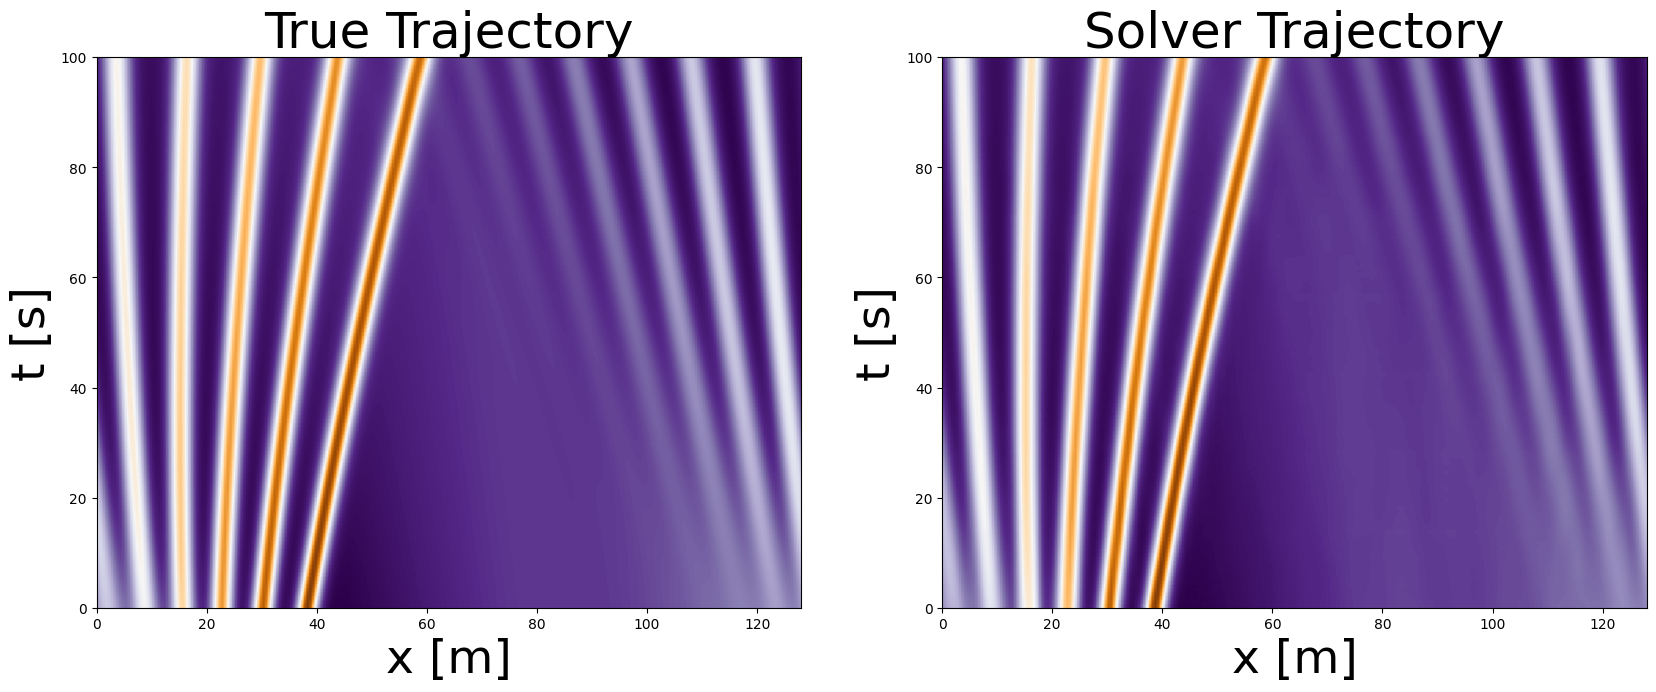

In [178]:
#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L=128
T=100
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].set_title('True Trajectory', fontsize=36)
axarr[1].set_title('Solver Trajectory', fontsize=36)
axarr[0].imshow(true_trajectory, extent=[0,L,0,T], cmap='PuOr_r')
axarr[1].imshow(trajectory, extent=[0,L,0,T], cmap='PuOr_r')
axarr[0].set_xlabel('x [m]', fontsize=34)
axarr[0].set_ylabel('t [s]', fontsize=34)
axarr[1].set_xlabel('x [m]', fontsize=34)
axarr[1].set_ylabel('t [s]', fontsize=34);

### Zero-Shot Resolution

In [179]:
u, _, _ = next(iter(train_loader))
print('Spatial resolution of training data: {}'.format(u[0].shape[1]))
print('Time resoltuion of training data: {}'.format(u[0].shape[0]))

Spatial resolution of training data: 256
Time resoltuion of training data: 140


In [180]:
# Set the size of the domain, and create the discretized grid.
np.random.seed(3)
L = 128
N = 2**9
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 140)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps_higher = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)

true_trajectory_h = sol_ps_higher.y.T[::-1]
print('The spatial resolution {} and the temporal {}'.format(true_trajectory_h.shape[1],true_trajectory_h.shape[0]))

The spatial resolution 512 and the temporal 140


In [189]:
start = 0
end_time = 20
trajectory_h = np.zeros(shape=(140,512))
correct_dir = np.flipud(true_trajectory_h)
trajectory_h[start:end_time,:] = correct_dir[start:end_time,:]
  
#take initial datapoints and generate the whole trajectory
with torch.no_grad():
  while start < 120:
    data = torch.from_numpy(trajectory_h[start:end_time,:]).to(device)
    data = torch.unsqueeze(data, 0)
    data = data.permute(0,2,1)
    pred = model(data.float())
    start += 20
    end_time += 20
    trajectory_h[start:end_time,:] = torch.squeeze(pred.permute(0,2,1)).cpu().detach().numpy()


trajectory_h = np.flipud(trajectory_h)

In [187]:
# start = 0
# end_time = 20
# trajectory_h = np.zeros(shape=(140,512))
# correct_dir = np.flipud(true_trajectory_h)
# trajectory_h[start:end_time,:] = correct_dir[start:end_time,:]
 
# #sample from test and generate
# with torch.no_grad():
#   data = torch.from_numpy(trajectory_h[start:end_time,:]).to(device)
#   data = torch.unsqueeze(data, 0)
#   data = data.permute(0,2,1).float()
#   start += end_time
#   end_time += time_future
#   while end_time <= 140:
#     pred = model(data)
#     data = pred
#     trajectory_h[start:end_time,:] = torch.squeeze(data.permute(0,2,1)).cpu().detach().numpy()
#     start = end_time
#     end_time += time_future

Text(0, 0.5, 't [s]')

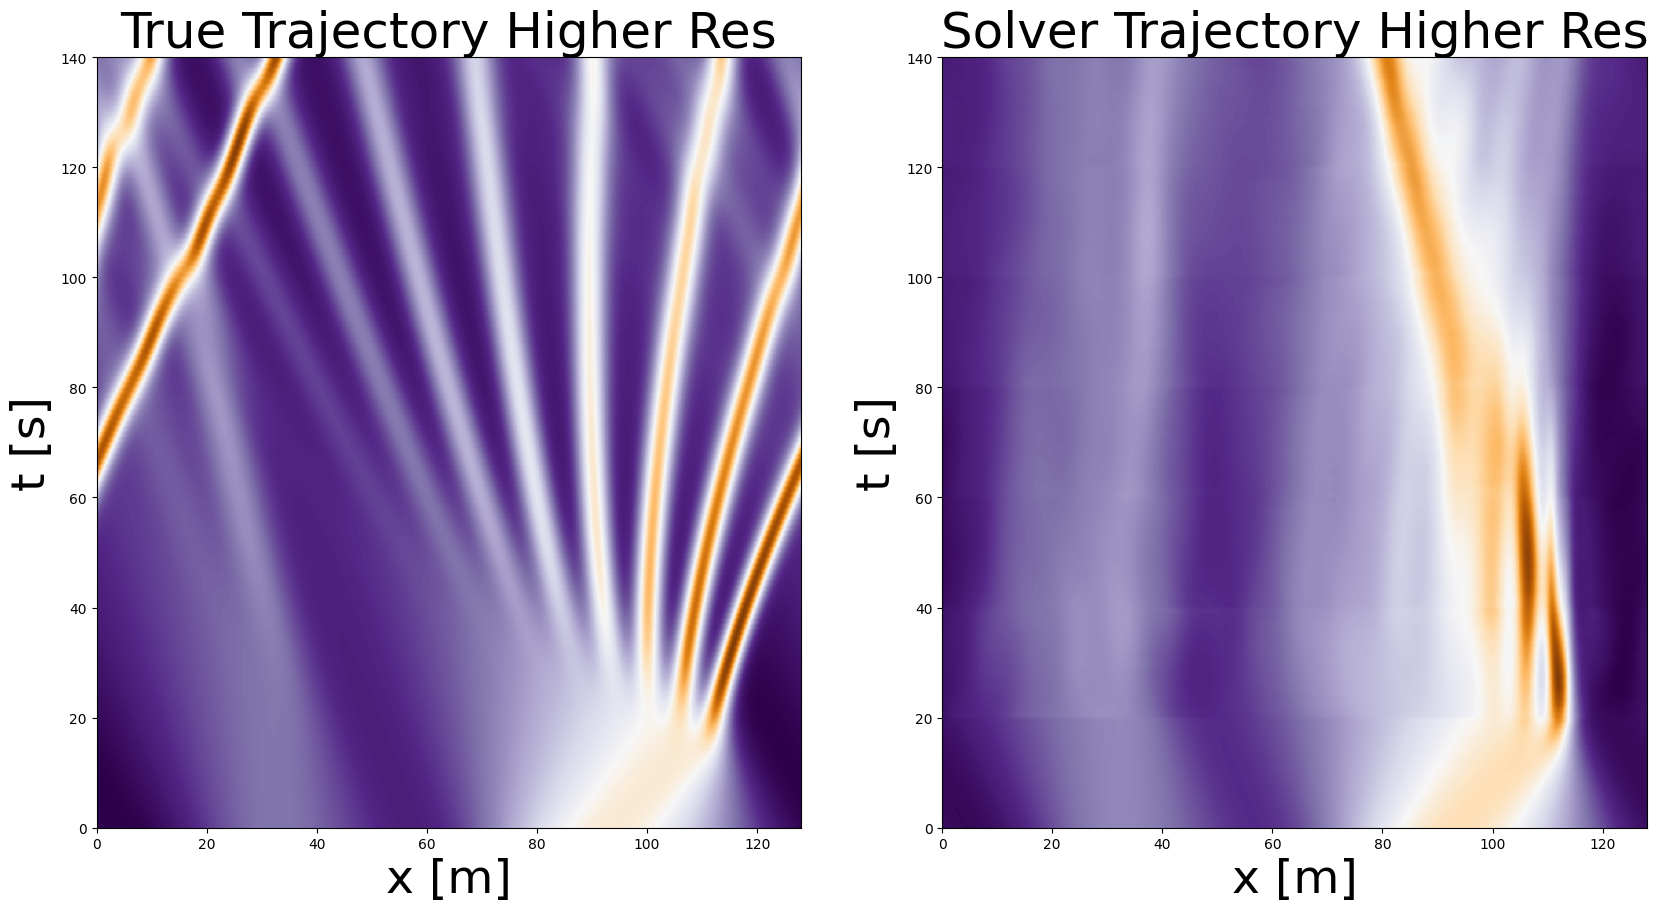

In [190]:
#Let's plot the true and predicted trajectory
L=128
T=140
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].set_title('True Trajectory Higher Res', fontsize=36)
axarr[1].set_title('Solver Trajectory Higher Res', fontsize=36)
axarr[0].imshow(true_trajectory_h, extent=[0,L,0,T], cmap='PuOr_r')
axarr[1].imshow(trajectory_h, extent=[0,L,0,T], cmap='PuOr_r')
axarr[0].set_xlabel('x [m]', fontsize=34)
axarr[0].set_ylabel('t [s]', fontsize=34)
axarr[1].set_xlabel('x [m]', fontsize=34)
axarr[1].set_ylabel('t [s]', fontsize=34)

## Fourier Filters compared to CNNs

One of the reasons proposed by Li et al. why fourier filters are more suited for dynamical problems than CNNs is because filters in convolution neural networks are usually local, while fourier filters are global sinusoidal functions. As such, CNNs are better in capturing local patterns such as edges and shapes, while fourier filters are better for representing continous functions (see image below). 
